# Transformers can do anything

Transformers version v4.30 introduces a new API: an API of **tools** and **agents** 🤩

It provides a natural language API on top of transformers: we define a set of curated tools, and design an agent to interpret natural language and to use these tools. It is extensible by design; we curated some relevant tools, but we'll show you how the system can be extended easily to use any tool.

Let's start with a few examples of what can be achieved with this new API. It is particularly powerful when it comes to multimodal tasks, so let's take it for a spin to generate images and read text out loud.

The accompanying docs are [Transformers Agent](https://huggingface.co/docs/transformers/en/transformers_agents) and [Custom Tools](https://huggingface.co/docs/transformers/en/custom_tools).

In [5]:
#@title Setup
transformers_version = "v4.29.0" #@param ["main", "v4.29.0"] {allow-input: true}

#print(f"Setting up everything with transformers version {transformers_version}")

!pip install huggingface_hub>=0.14.1 git+https://github.com/huggingface/transformers@$transformers_version -q diffusers accelerate datasets torch soundfile sentencepiece opencv-python openai

import IPython
import soundfile as sf

def play_audio(audio):
    sf.write("speech_converted.wav", audio.numpy(), samplerate=16000)
    return IPython.display.Audio("speech_converted.wav")

# from huggingface_hub import notebook_login
# notebook_login()

# Do anything with Transformers

We'll start by instantiating an **agent**, which is a large language model (LLM). 

We recommend using the OpenAI for the best results, but fully open-source models such as StarCoder or OpenAssistant are also available.

In [1]:
#@title Agent init
agent_name = "StarCoder (HF Token)" #@param ["StarCoder (HF Token)", "OpenAssistant (HF Token)", "OpenAI (API Key)"]

import getpass

if agent_name == "StarCoder (HF Token)":
    from transformers.tools import HfAgent
    agent = HfAgent("https://api-inference.huggingface.co/models/bigcode/starcoder")
    print("StarCoder is initialized 💪")
elif agent_name == "OpenAssistant (HF Token)":
    from transformers.tools import HfAgent
    agent = HfAgent(url_endpoint="https://api-inference.huggingface.co/models/OpenAssistant/oasst-sft-4-pythia-12b-epoch-3.5")
    print("OpenAssistant is initialized 💪")
if agent_name == "OpenAI (API Key)":
    from transformers.tools import OpenAiAgent
    pswd = getpass.getpass('OpenAI API key:')
    agent = OpenAiAgent(model="text-davinci-003", api_key=pswd)
    print("OpenAI is initialized 💪")

/home/Startupcolors/doze/wound/notebooks/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


StarCoder is initialized 💪


## Using the agent

The agent is initialized! We now have access to the full power of the tools it has access to.

Let's use it 😎

In [3]:
boat = agent.run("Generate an image of a doctor holding an ipad examining a patient.")
boat

==Explanation from the agent==
I will use the following  tools: `image_segmenter` to create a segmentation mask of the doctor, then `image_transformer` to transform the image according to the segmentation mask.


==Code generated by the agent==
doctor_mask = image_segmenter(image=image, label="doctor")
doctor_image = image_transformer(image=image, prompt=doctor_mask)


==Result==


A new version of the following files was downloaded from https://huggingface.co/space/huggingface-tools/image-transformation:
- image_transformation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Evaluation of the code stopped at line 0 before the end because of the following error:
The variable `image` is not defined.


If you'd like to hand objects (or previous results!) to the agent, you can do so by passing a variable directly, and mentioning between backticks the name of the variable passed. For example, if I want to re-use the previous boat generation:

In [ ]:
caption = agent.run("Can you caption the `boat_image`?", boat_image=boat)
caption

==Explanation from the agent==
I will use the following  tool: `image_captioner` to generate a caption for the image.


==Code generated by the agent==
caption = image_captioner(boat_image)


==Result==


'a boat floating in the ocean with a small island in the background'

Agents vary in competency and their capacity to handle several instructions at once; however the strongest of them (such as OpenAI's) are able to handle complex instructions such as the following three-part instruction:

In [ ]:
audio = agent.run("Can you generate an image of a boat? Please read out loud the contents of the image afterwards")
play_audio(audio)

Where this works great is when your query implies the use of tools which you haven't described directly. An exemple of this would be the following query: "Read out loud the summary of hf.co"

Here we're asking the model to perform three steps at once:
- Fetch the website https://huggingface.co
- Summarize it
- Translate the text to speech

In [ ]:
audio = agent.run("Read out loud the summary of http://hf.co")
play_audio(audio)

==Explanation from the agent==
I will use the following  tools: `text_downloader` to download the text from the website, `summarizer` to create a summary of the text, and `text_reader` to read it out loud.


==Code generated by the agent==
text = text_downloader("https://hf.co")
summarized_text = summarizer(text)
print(f"Summary: {summarized_text}")
audio_summary = text_reader(summarized_text)


==Result==
Summary: Hugging Face is an AI community building the future. More than 5,000 organizations are using Hugging Face's AI chat models. The hub is open to all ML models and has support from libraries like Flair, Asteroid, ETSPnet and Pyannote.


Using the best agents works well 🎉

### Chat mode

So far, we've been using the agent by using it's `.run` command. But that's not the only command it has access to; the second command it has access to is `.chat`, which enables using it in chat mode.

The difference between the two is relative to their memory:
- `.run` does not keep memory across runs, but performs better for multiple operations at once (such as running two, or three tools in a row from a given instruction)
- `.chat` keeps memory across runs, but performs better at single instructions.

Let's use it in chat mode!

In [2]:
agent.chat("Show me an an image of a doctor holding ipad examining a patient")

==Explanation from the agent==
I will use the tool `image_captioner` to generate a caption for the image.


==Code generated by the agent==
caption = image_captioner(image)
print(f"Caption: {caption}")


==Result==
Evaluation of the code stopped at line 0 before the end because of the following error. Copy paste the following error message and send it back to the agent:
I get an error: 'The variable `image` is not defined.'


What if we wanted to change something in the image? For example, move the capybaras to a snowy environment

==Explanation from the agent==
I will use the tool `image_transformer` to transform the image so that it snows.


==Code generated by the agent==
transformed_image = image_transformer(image, prompt="Snowy")


==Result==


  0%|          | 0/50 [00:00<?, ?it/s]

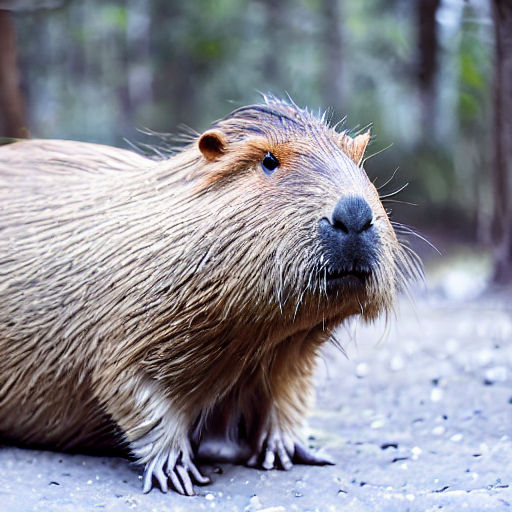

In [ ]:
agent.chat("Transform the image so that it snows")

Now what if we wanted to remove the capybara in favor of something else? We could ask it to show us a mask of the capybara in the image:

==Explanation from the agent==
I will use the tool `image_segmenter` to create a segmentation mask of the image.


==Code generated by the agent==
mask = image_segmenter(image, label="doctor and patient")


==Result==


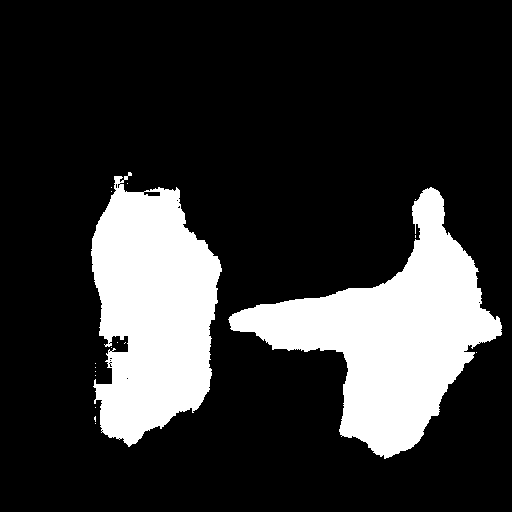

In [12]:
agent.chat("Show me a mask of the image")

Having access to the past history is great to repeatedly iterate on a given prompt. However, it has its limitations and sometimes you'd like to have a clean history. In order to do so, you can use the following method:

In [ ]:
agent.prepare_for_new_chat()

## Tools

So far we've been using the tools that the agent has access to. These tools are the following:

- **Document question answering**: given a document (such as a PDF) in image format, answer a question on this document (Donut)
- **Text question answering**: given a long text and a question, answer the question in the text (Flan-T5)
- **Unconditional image captioning**: Caption the image! (BLIP)
- **Image question answering**: given an image, answer a question on this image (VILT)
- **Image segmentation**: given an image and a prompt, output the segmentation mask of that prompt (CLIPSeg)
- **Speech to text**: given an audio recording of a person talking, transcribe the speech into text (Whisper)
- **Text to speech**: convert text to speech (SpeechT5)
- **Zero-shot text classification**: given a text and a list of labels, identify to which label the text corresponds the most (BART)
- **Text summarization**: summarize a long text in one or a few sentences (BART)
- **Translation**: translate the text into a given language (NLLB)

We also support the following community-based tools:

- **Text downloader**: to download a text from a web URL
- **Text to image**: generate an image according to a prompt, leveraging stable diffusion
- **Image transformation**: transforms an image

We can therefore use a mix and match of different tools by explaining in natural language what we would like to do.

But what about adding new tools? Let's take a look at how to do that 

### Adding new tools

We'll add a very simple tool so that the demo remains simple: we'll use the awesome cataas (Cat-As-A-Service) API to get random cats on each run.

We can get a random cat with the following code:

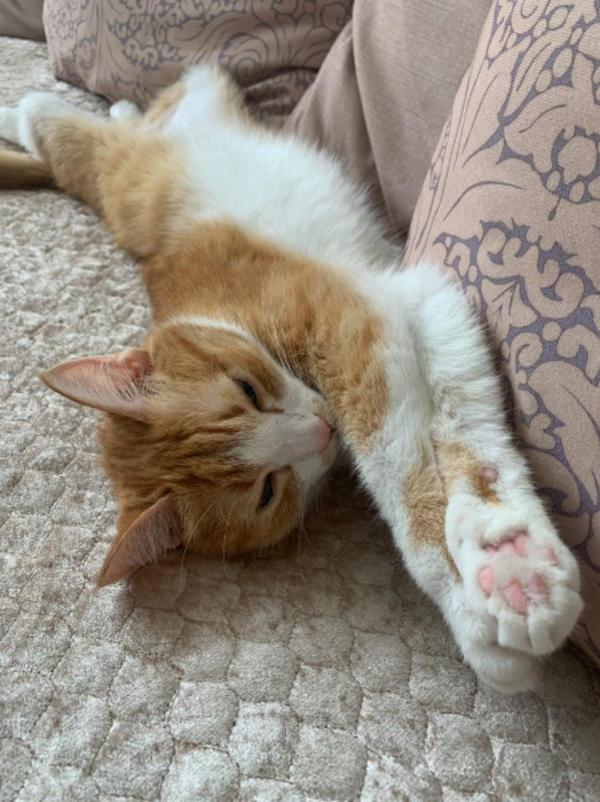

In [13]:
import requests
from PIL import Image

image = Image.open(requests.get('https://cataas.com/cat', stream=True).raw)
image

Let's create a tool that can be used by our system!

All tools depend on the superclass Tool that holds the main attributes necessary. We'll create a class that inherits from it:

In [14]:
from transformers import Tool

class CatImageFetcher(Tool):
    pass

This class has a few needs:

- An attribute name, which corresponds to the name of the tool itself. To be in tune with other tools which have a performative name, we'll name it text-download-counter.
- An attribute description, which will be used to populate the prompt of the agent.
- inputs and outputs attributes. Defining this will help the python interpreter make educated choices about types, and will allow for a gradio-demo to be spawned when we push our tool to the Hub. They're both a list of expected values, which can be text, image, or audio.
- A __call__ method which contains the inference code. This is the code we've played with above!

Here’s what our class looks like now:

In [15]:
from transformers import Tool
from huggingface_hub import list_models


class CatImageFetcher(Tool):
    name = "cat_fetcher"
    description = ("This is a tool that fetches an actual image of a cat online. It takes no input, and returns the image of a cat.")

    inputs = []
    outputs = ["text"]

    def __call__(self):
        return Image.open(requests.get('https://cataas.com/cat', stream=True).raw).resize((256, 256))

We can simply use and test the tool directly:

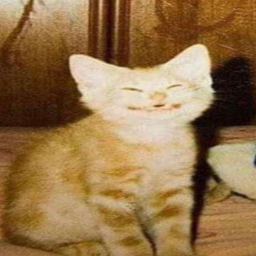

In [16]:
tool = CatImageFetcher()
tool()

In order to pass the tool to the agent, we recommend instantiating the agent with the tools directly:

In [17]:
from transformers.tools import HfAgent

agent = HfAgent("https://api-inference.huggingface.co/models/bigcode/starcoder", additional_tools=[tool])

Let's try to have the agent use it with other tools!

In [18]:
agent.run("Fetch an image of a cat online and caption it for me")

==Explanation from the agent==
I will use the following  tools: `cat_fetcher` to fetch an image of a cat, then `image_captioner` to caption it.


==Code generated by the agent==
cat = cat_fetcher()
caption = image_captioner(cat)


==Result==


/home/Startupcolors/doze/wound/notebooks/.venv/lib/python3.8/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'a cat sitting on a desk looking at a computer'

Success 🎉

The tool was used to fetch a cat image, and the image captioning tool was used shortly after in order to caption that same image.

Finally, we recommend pushing the tool to the Hub in order to have others benefit from it. Here is the documentation that contains more information in order to do so: [Adding a new tool](https://huggingface.co/docs/transformers/en/custom_tools#creating-a-new-tool)

Thanks for following through with the notebook! We're looking forward to the tools you'll push, which will help empower all agents.